In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import time as time
import pandas as pd
from scipy import stats
import math

# Set the cosmology (distances in $Mpc/h$)

In [3]:
from astropy.cosmology import FlatLambdaCDM
cosmology = FlatLambdaCDM(H0=100.0, Om0=0.319, Ob0=0.049, Tcmb0=2.725)

# Download and load catalogue

## Query to get the catalogue from CosmoHUB

```sql
SELECT mice2.ra_gal, 
       mice2.dec_gal, 
       mice2.z_cgal, 
       mice2_ia.eps1_gal, 
       mice2_ia.eps2_gal, 
       mice2.sdss_r_true - 0.8 * (ATAN(1.5 * mice2.z_cgal) - 0.1489) as mag_sdss_r 
FROM mice2_ia_20210203_c as mice2_ia 
JOIN cosmohub.micecatv2_0_view as mice2 
ON mice2.unique_gal_id==mice2_ia.unique_gal_id 
WHERE 
mice2.z_cgal < 0.35 
AND 
mice2.z_cgal > 0.15 
AND 
mice2.sdss_r_true - 0.8 * (ATAN(1.5 * mice2.z_cgal) - 0.1489) < 17.7
```

## Load the catalogue

In [4]:
path = '/data/astro/scratch/egonzale/' # where the catalogue is saved
file_name = 'MICE_IA_example_22052.parquet' # name of the catalogue

In [5]:
catalog_filename = path+file_name
print('Reading catalogue '+catalog_filename)
cat_input = pd.read_parquet(catalog_filename)


Reading catalogue /data/astro/scratch/egonzale/MICE_IA_example_22052.parquet


In [6]:
cat_input

,ra_gal,dec_gal,z_cgal,eps1_gal,eps2_gal,mag_sdss_r
0,45.105341,17.931202,0.15288,0.068511,0.021699,17.053782
1,44.980870,17.960592,0.15309,0.352040,-0.001282,16.947543
2,45.660744,17.512341,0.15252,0.142230,-0.110380,17.565192
3,43.668229,16.102009,0.15016,0.008911,-0.028600,17.339886
4,43.213686,17.717652,0.15170,-0.505704,-0.041507,17.499128
...,...,...,...,...,...,...
70418,59.639502,13.160986,0.26821,-0.168962,0.217767,17.459120
70419,60.749044,12.273790,0.27103,0.221832,-0.248740,17.668211
70420,56.291383,10.872940,0.27722,0.095308,-0.285069,17.686857
70421,52.248698,20.573132,0.29538,-0.457101,0.000787,17.620458


## Define column names to be used and modify the catalogue (if necessary)

In [7]:
col_names = ['ra_gal','dec_gal','r_com','eps1_gal','eps2_gal', 'weight']
ra,dec,d,g1,g2, w = col_names
redshift = 'z_cgal'

In [8]:
cat_input.columns

Index(['ra_gal', 'dec_gal', 'z_cgal', 'eps1_gal', 'eps2_gal', 'mag_sdss_r'], dtype='object')

In [9]:
cat_input[g1] = -1*cat_input[g1]
cat_input[g2] = cat_input[g2]
cat_input

,ra_gal,dec_gal,z_cgal,eps1_gal,eps2_gal,mag_sdss_r
0,45.105341,17.931202,0.15288,-0.068511,0.021699,17.053782
1,44.980870,17.960592,0.15309,-0.352040,-0.001282,16.947543
2,45.660744,17.512341,0.15252,-0.142230,-0.110380,17.565192
3,43.668229,16.102009,0.15016,-0.008911,-0.028600,17.339886
4,43.213686,17.717652,0.15170,0.505704,-0.041507,17.499128
...,...,...,...,...,...,...
70418,59.639502,13.160986,0.26821,0.168962,0.217767,17.459120
70419,60.749044,12.273790,0.27103,-0.221832,-0.248740,17.668211
70420,56.291383,10.872940,0.27722,-0.095308,-0.285069,17.686857
70421,52.248698,20.573132,0.29538,0.457101,0.000787,17.620458


## Define shape and position catalogues

In [10]:
mcut = 17.3

In [11]:
positions = cat_input
shapes    = cat_input[cat_input.mag_sdss_r < mcut]
len(positions), len(shapes)

(70423, 20498)

Text(0, 0.5, 'N')

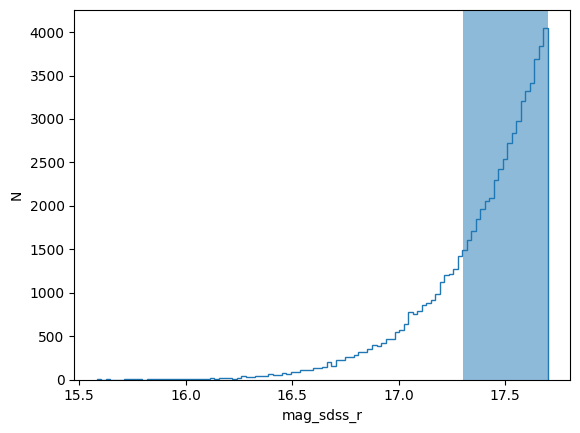

In [12]:
plt.hist(positions.mag_sdss_r,100,histtype='step')
plt.axvspan(mcut,max(positions.mag_sdss_r),alpha=0.5)
plt.xlabel('mag_sdss_r')
plt.ylabel('N')

In [13]:
positions.loc[:,'weight'] = np.ones(len(positions))

In [14]:
shapes.loc[:,'weight'] = np.clip((1./shapes.mag_sdss_r - 1./19)/0.01,0.,1)

/tmp/ipykernel_2971668/2915581097.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shapes.loc[:,'weight'] = np.clip((1./shapes.mag_sdss_r - 1./19)/0.01,0.,1)


Text(0, 0.5, 'weight')

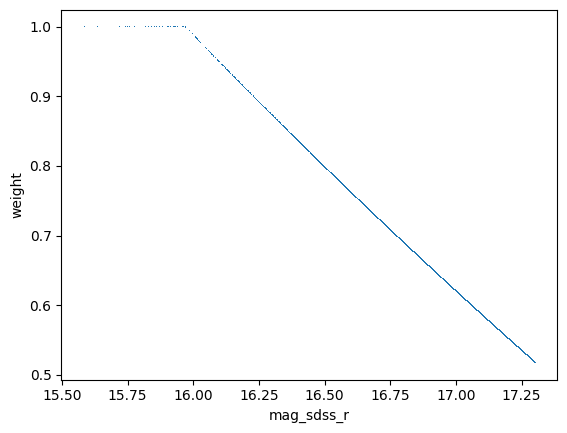

In [15]:
plt.plot(shapes.mag_sdss_r,shapes['weight'],',')
plt.xlabel('mag_sdss_r')
plt.ylabel('weight')

## Compute randoms 

In [16]:
from IACorr import make_randoms_lightcone as make_randoms

In [17]:
random_positions = make_randoms(positions[ra], positions[dec], positions[redshift], len(positions)*10, col_names=[ra,dec,redshift])
random_shapes    = make_randoms(shapes[ra], shapes[dec], shapes[redshift], len(shapes)*10, col_names=[ra,dec,redshift])

/nfs/pic.es/user/e/egonzale/env/scipic_home/lib64/python3.9/site-packages/IACorr/compute_IA_corr_from_data.py:1704: RankWarning: Polyfit may be poorly conditioned
  poly = np.polyfit(x,y,n)
/nfs/pic.es/user/e/egonzale/env/scipic_home/lib64/python3.9/site-packages/IACorr/compute_IA_corr_from_data.py:1704: RankWarning: Polyfit may be poorly conditioned
  poly = np.polyfit(x,y,n)


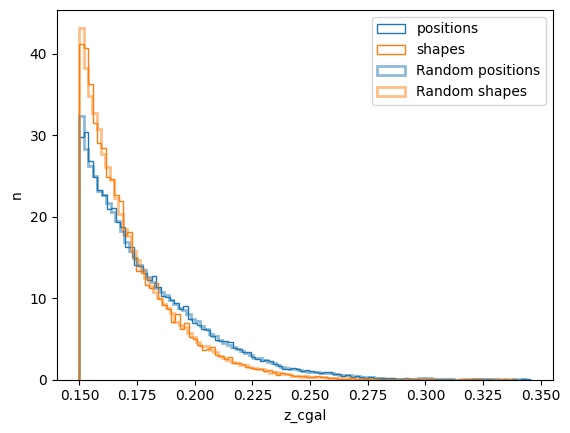

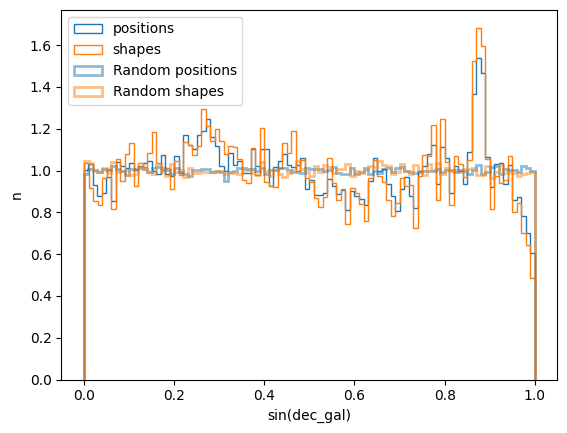

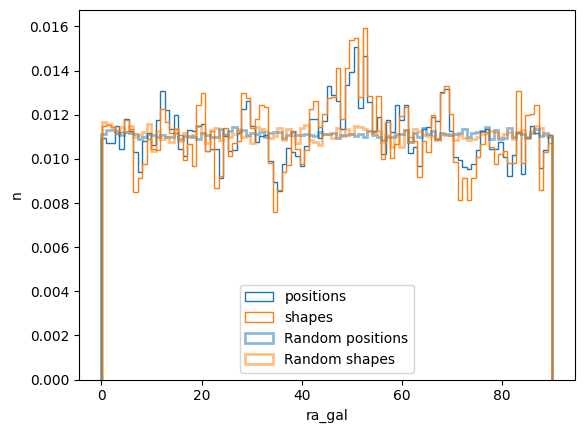

In [18]:
plt.figure()
plt.hist(positions[redshift],100,histtype='step',density=True,label='positions')
plt.hist(shapes[redshift],100,histtype='step',density=True,label='shapes')
plt.hist(random_positions[redshift],100,histtype='step',density=True,label='Random positions',lw=2,alpha=0.5,color='C0')
plt.hist(random_shapes[redshift],100,histtype='step',density=True,label='Random shapes',lw=2,alpha=0.5,color='C1')
plt.xlabel(redshift)
plt.ylabel('n')
plt.legend()


plt.figure()
plt.hist(np.sin(np.deg2rad(positions[dec])),100,histtype='step',density=True,label='positions')
plt.hist(np.sin(np.deg2rad(shapes[dec])),100,histtype='step',density=True,label='shapes')
plt.hist(np.sin(np.deg2rad(random_positions[dec])),100,histtype='step',density=True,label='Random positions',lw=2,alpha=0.5,color='C0')
plt.hist(np.sin(np.deg2rad(random_shapes[dec])),100,histtype='step',density=True,label='Random shapes',lw=2,alpha=0.5,color='C1')
plt.xlabel('sin('+dec+')')
plt.ylabel('n')
plt.legend()

plt.figure()
plt.hist(positions[ra],100,histtype='step',density=True,label='positions')
plt.hist(shapes[ra],100,histtype='step',density=True,label='shapes')
plt.hist(random_positions[ra],100,histtype='step',density=True,label='Random positions',lw=2,alpha=0.5,color='C0')
plt.hist(random_shapes[ra],100,histtype='step',density=True,label='Random shapes',lw=2,alpha=0.5,color='C1')
plt.xlabel(ra)
plt.ylabel('n')
plt.legend()



## Compute comoving distances

In [19]:
positions.loc[:,d] = cosmology.comoving_distance(positions[redshift]).value
shapes.loc[:,d]    = cosmology.comoving_distance(shapes[redshift]).value
random_positions[d] = cosmology.comoving_distance(random_positions[redshift]).value
random_shapes[d]    = cosmology.comoving_distance(random_shapes[redshift]).value

/tmp/ipykernel_2971668/3052891530.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shapes.loc[:,d]    = cosmology.comoving_distance(shapes[redshift]).value


# Compute correlations

## Set-up parameters

In [20]:
# parameters related with bins
nbins = 10 # number of radial bins
rmin = 0.2 # minimum value for rp (r in case of the quadrupole)
rmax = 50. # maximum value for rp (r in case of the quadrupole)
pi_max = 30. # maximum value along l.o.s. (Pi) 
npi = 5 # number of bins in Pi
mubins = 10 # number of bins in mu

# Related to JK patches
NPatches = int(nbins**(3./2.))
print('Number of patches',NPatches)
# Other configuration parameters
ncores = 30 # Number of cores to run in parallel
slop = 0. # Resolution for treecorr
box = False # Indicates if the data corresponds to a box, otherwise it will assume a lightcone
exact_position = True # Indicates if the coordinates are exactly provided (e.g. simulated data 
# without any error added in the position). Otherwise it will assume that the positions are not
# exact and will use ra, dec to match the catalogues. If this parameter is set as True, it
# will neglect box and it will set it as False
sky_threshold = 1.0 # Threshold for matching the catalogues in arcsecond, used if exact_position
#is set to True.
grid_resolution = 50 # Resolution of the grid used to compute the quadrupole, a lower number will
#speed up the computation but reaches to larger radial distances.

Number of patches 31


## Make configuration input

In [21]:
config = {'col_names': col_names,
          'nbins': nbins,
          'rmin': rmin,
          'rmax': rmax,
          'pi_max': pi_max,
          'npi': npi,
          'grid_resolution': grid_resolution,
          'mubins': mubins,
          'NPatches': NPatches,
          'ncores': ncores,
          'slop': slop,
          'box': box,
          'exact_position': exact_position,
          'sky_threshold': sky_threshold,
         }
          

## Initialize 

In [22]:
from IACorr import compute_2p_corr

In [23]:
corr = compute_2p_corr(positions,shapes,random_positions,random_shapes,config)
print(corr.__doc__)


    Computes correlation estimators useful to measure Intrinsic Alignment.

    This class calculates the projected galaxy-galaxy (wgg), galaxy-shear (wg+, wgx),
    and the quadrupole component of the galaxy-shear (wg+2, wgx2) correlations.
    
    Arguments:
    -----------
        positions (pandas array): Catalogue of galaxy positions.
        shapes (pandas array): Catalogue of galaxy positions and shapes.
        randoms_positions (pandas array): Catalogue of randoms positions.
        randoms_shapes (pandas array): Catalogue of random positions for the shape catalogue.

    Attributes:
    -----------
        config (dict): Configuration dictionary for the computation.
        scat (treecorr.Catalog): Catalog of shapes.
        pcat (treecorr.Catalog): Catalog of positions.
        rpcat (treecorr.Catalog): Catalog of random positions.
        rscat (treecorr.Catalog): Catalog of random positions.
        wgg (object, optional): Projected galaxy-galaxy (position-position) corr

## Compute correlations

## $w_{gg}$

In [24]:
%%time
corr.compute_wgg()

CPU times: user 18min 25s, sys: 2.24 s, total: 18min 27s
Wall time: 40.5 s


In [25]:
print(corr.wgg.__doc__)


        Computes the galaxy-galaxy correlation.
        
        Arguments:
        -----------
            config (dict): Configuration dictionary for the computation.
            dcat (treecorr.Catalog): Catalog of data points.
            rcat (treecorr.Catalog): Catalog of random points.        
        Attributes:
        -----------
            rp (ndarray): Array of projected radial separation bins.
            mean_logrp (ndarray): Mean logarithmic projected radial separation bins.
            mean_rp (ndarray): Mean projected radial separation bins.
            Pi (ndarray): Array of l.o.s. separation bins.
            xi (ndarray): 2D Correlation function in bins of projected and l.o.s distance.
            xi_jk (ndarray): 2D Correlation function for each Jackknife resampling.
            xip (ndarray): Projected correlation function across the l.o.s.
            xip_jk (ndarray): Projected correlation function across the l.o.s for each Jackknife resampling.
            cov

## Cross $w_{gg}$

In [26]:
%%time
corr.compute_wgg_cross()

CPU times: user 11min 43s, sys: 546 ms, total: 11min 43s
Wall time: 25.4 s


In [27]:
print(corr.wgg_cross.__doc__)


        Computes the cross galaxy-galaxy correlation.
        
        Arguments:
        -----------
            dcat1 (treecorr.Catalog): Catalog of data points.
            dcat2 (treecorr.Catalog): Catalog of data points.
            rcat1 (treecorr.Catalog): Catalog of random points for dcat1.        
            rcat2 (treecorr.Catalog): Catalog of random points for dcat2.        
            config (dict): Configuration dictionary for the computation.
        Attributes:
        -----------
            rp (ndarray): Array of projected radial separation bins.
            mean_logrp (ndarray): Mean logarithmic projected radial separation bins.
            mean_rp (ndarray): Mean projected radial separation bins.
            Pi (ndarray): Array of l.o.s. separation bins.
            xi (ndarray): 2D Correlation function in bins of projected and l.o.s distance.
            xi_jk (ndarray): 2D Correlation function for each Jackknife resampling.
            xip (ndarray): Projected c

## $w_{g+}$,$w_{g\times}$

In [28]:
%%time
corr.compute_wgp()

CPU times: user 8min 30s, sys: 66.2 ms, total: 8min 30s
Wall time: 18.7 s


In [29]:
print(corr.wgp.__doc__)


    Computes the galaxy-shear correlation.
    
    Arguments:
    -----------
        dcat (treecorr.Catalog): Catalog of galaxy points.
        scat (treecorr.Catalog): Catalog of galaxy shapes.
        rpcat (treecorr.Catalog): Catalog of random points for positions.        
        rscat (treecorr.Catalog): Catalog of random points for shapes.
        config (dict): Configuration dictionary for the computation.
    Attributes:
    -----------
        rp (ndarray): Array of projected radial separation bins.
        mean_logrp (ndarray): Mean logarithmic projected radial separation bins.
        mean_rp (ndarray): Mean projected radial separation bins.
        Pi (ndarray): Array of l.o.s. of the mean value pi separation bins.
        Pi_bins (ndarray): Array of l.o.s. of the upper and lower limits of the separation bins.
        xi (ndarray): 2D Correlation function in bins of projected and l.o.s distance.
        xi_jk (ndarray): 2D Correlation function for each Jackknife resampli

In [30]:
print(corr.wgx.__doc__)


    Computes the projected cross component for galaxy-shear correlation. 
    
    Arguments:
    -----------
        xi (ndarray): 2D galaxy-shear cross correlation function in bins of 3D radial coordinate and mu.
        xi_jk (ndarray): 2D galaxy-shear cross correlation function for each Jackknife resampling.
        rcor (ndarray): Array of projected radial separation bins.        
        pcor (ndarray): Array of the upper and lower limits of the separation bins.
        L_mu_jk (optional, ndarray): Legendre polinomials.
        factor (optional,float): Factor to be included in the integration.

    Attributes:
    -----------
        r (optional, ndarray): Array of 3D radial separation bins.
        mu (optional, ndarray): Array of mu (cosine of the angle) separation bins.
        rp (optional, ndarray): Array of projected radial separation bins.
        pi (optional, ndarray): Array of l.o.s. separation bins.
        xi (ndarray): 2D galaxy-shear cross correlation function.
   

## $w_{g+,2}$,$w_{g\times,2}$

In [31]:
%%time
corr.compute_wgp2()

CPU times: user 7h 23min 40s, sys: 9.95 s, total: 7h 23min 50s
Wall time: 16min 35s


In [32]:
print(corr.wgp2.__doc__)


    Computes the quadrupole component for galaxy-shear correlation. Eq 7 in arXiv 2307.02545.
    
    Arguments:
    -----------
        dcat (treecorr.Catalog): Catalog of galaxy points.
        scat (treecorr.Catalog): Catalog of galaxy shapes.
        rpcat (treecorr.Catalog): Catalog of random points for positions.        
        rscat (treecorr.Catalog): Catalog of random points for shapes.        
        config (dict): Configuration dictionary for the computation.
    Attributes:
    -----------
        r (ndarray): Array of projected radial separation bins.
        mu (ndarray): Array of mu (cosine of the angle) separation bins.
        xi (ndarray): 2D galaxy-shear plus correlation function in bins of 3D radial coordinate and mu.
        xi_jk (ndarray): 2D galaxy-shear plus correlation function for each Jackknife resampling.
        xip (ndarray): Projected correlation function across mu.
        xip_jk (ndarray): Projected correlation function across mu for each Jackknife

In [33]:
print(corr.wgx2.__doc__)


    Computes the projected cross component for galaxy-shear correlation. 
    
    Arguments:
    -----------
        xi (ndarray): 2D galaxy-shear cross correlation function in bins of 3D radial coordinate and mu.
        xi_jk (ndarray): 2D galaxy-shear cross correlation function for each Jackknife resampling.
        rcor (ndarray): Array of projected radial separation bins.        
        pcor (ndarray): Array of the upper and lower limits of the separation bins.
        L_mu_jk (optional, ndarray): Legendre polinomials.
        factor (optional,float): Factor to be included in the integration.

    Attributes:
    -----------
        r (optional, ndarray): Array of 3D radial separation bins.
        mu (optional, ndarray): Array of mu (cosine of the angle) separation bins.
        rp (optional, ndarray): Array of projected radial separation bins.
        pi (optional, ndarray): Array of l.o.s. separation bins.
        xi (ndarray): 2D galaxy-shear cross correlation function.
   

# Make plots

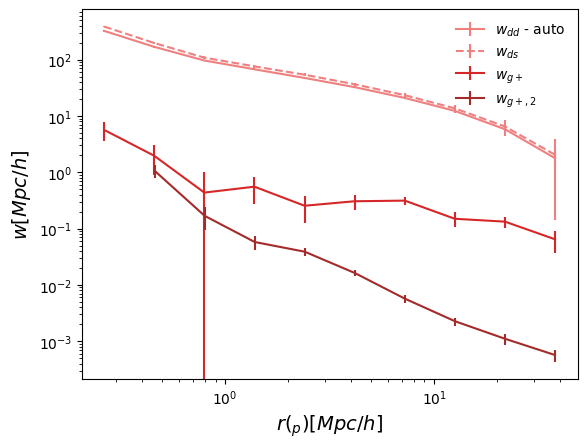

In [34]:
plt.errorbar(corr.wgg.rp,corr.wgg.xip,yerr=corr.wgg.std_from_cov,label=r'$w_{dd}$ - auto',c='lightcoral')
plt.errorbar(corr.wgg_cross.rp,corr.wgg_cross.xip,yerr=corr.wgg_cross.std_from_cov,label=r'$w_{ds}$',c='lightcoral',ls='--')
plt.errorbar(corr.wgp.rp,corr.wgp.xip,yerr=corr.wgp.std_from_cov,label=r'$w_{g+}$',c='C3')
plt.errorbar(corr.wgp2.r,corr.wgp2.xip,yerr=corr.wgp2.std_from_cov,label=r'$w_{g+,2}$',c='brown')
plt.xscale('log')
plt.yscale('log')
plt.ylabel(r'$w[Mpc/h]$',fontsize=14)
plt.xlabel(r'$r(_p) [Mpc/h]$',fontsize=14)
plt.legend(frameon=False,loc=1)

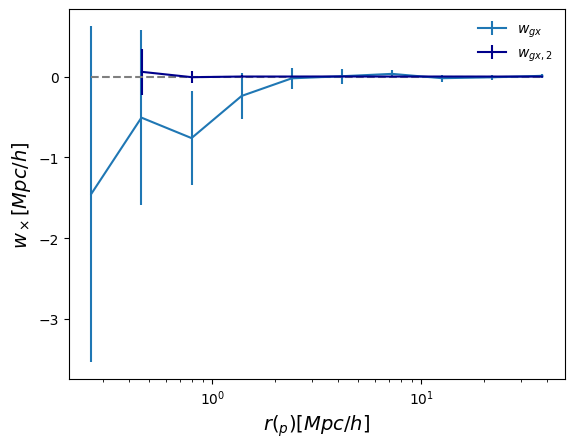

In [35]:
plt.errorbar(corr.wgp.rp,corr.wgx.xip,yerr=corr.wgp.std_from_cov,label=r'$w_{gx}$',c='C0')
plt.errorbar(corr.wgp2.r,corr.wgx2.xip,yerr=corr.wgp2.std_from_cov,label=r'$w_{gx,2}$',c='darkblue')
plt.plot(corr.wgp.rp,corr.wgp.rp*0.,'C7--')
plt.xscale('log')
plt.ylabel(r'$w_\times[Mpc/h]$',fontsize=14)
plt.xlabel(r'$r(_p) [Mpc/h]$',fontsize=14)
plt.legend(frameon=False)

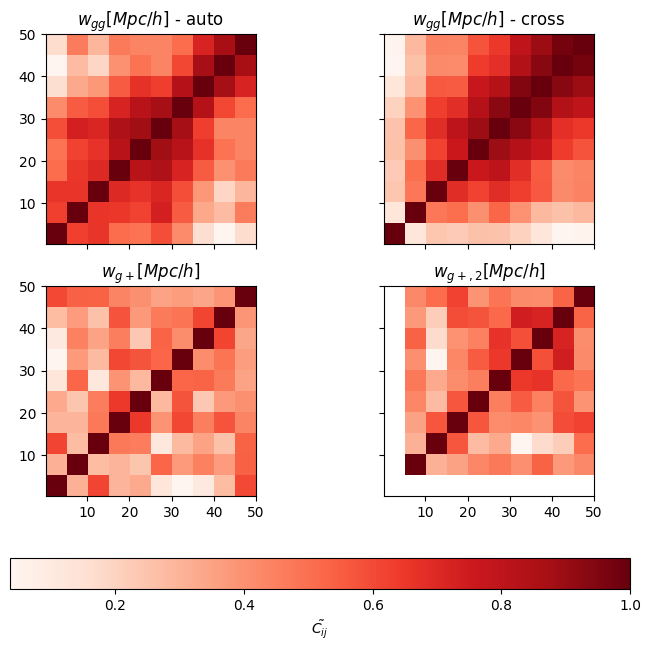

In [36]:
fig, ax = plt.subplots(2,2, figsize=(8,8),sharex = True,sharey=True)
ax = ax.flatten()
im = ax[0].imshow(corr.wgg.cov_jk_norm,origin='lower',extent=[rmin,rmax,rmin,rmax],cmap='Reds')
ax[1].imshow(corr.wgg_cross.cov_jk_norm,origin='lower',extent=[rmin,rmax,rmin,rmax],cmap='Reds')
ax[2].imshow(corr.wgp.cov_jk_norm,origin='lower',extent=[rmin,rmax,rmin,rmax],cmap='Reds')
ax[3].imshow(corr.wgp2.cov_jk_norm,origin='lower',extent=[rmin,rmax,rmin,rmax],cmap='Reds')

ax[0].set_title(r'$w_{gg}[Mpc/h]$ - auto')
ax[1].set_title(r'$w_{gg}[Mpc/h]$ - cross')
ax[2].set_title(r'$w_{g+}[Mpc/h]$')
ax[3].set_title(r'$w_{g+,2}[Mpc/h]$')
plt.colorbar(im, label=r'$\tilde{C_{ij}}$',ax = ax, orientation='horizontal',pad=0.1)

# Fast $w_{g+}$ and $w_{g+,2}$

## It computes first the number of pairs in the randoms (RR) and asumes that SR = 0

In [37]:
%%time
corr.compute_wgp_fast()

Computing normalisation factors and the number of pairs in the random catalogues...
Everything ok :) Finished
CPU times: user 6min 26s, sys: 96.4 ms, total: 6min 26s
Wall time: 14.6 s


In [38]:
print(corr.wgp_fast.__doc__)


    Allows to compute the projected galaxy-shear correlation (wg+). This version allows the pre-computation of the random number of pairs and then it can be executed to compute the galaxy-shear correlation varying the shapes of the galaxies in the shape catalogue.
    
    Arguments:
    -----------
        dcat (treecorr.Catalog): Catalog of galaxy points.
        scat (treecorr.Catalog): Catalog of galaxy shapes.
        rpcat (treecorr.Catalog): Catalog of random points for positions.        
        rscat (treecorr.Catalog): Catalog of random points for shapes.        
        config (dict): Configuration dictionary for the computation.
    Methods:
    -----------
        execute(new_shapes=False,shapes=[]): Allows the computation of the projected galaxy-shape correlation. It can be used giving a different shape catalogue as input.
    


In [39]:
%%time
corr.wgp_fast.use_new_shapes(shapes)
corr.wgp_fast.execute()

CPU times: user 4min 54s, sys: 538 ms, total: 4min 54s
Wall time: 12.4 s


In [40]:
%%time
corr.compute_wgp2_fast()

Computing normalisation factors and the number of pairs in the random catalogues...
Everything ok :) Finished
CPU times: user 3h 50min 4s, sys: 3.82 s, total: 3h 50min 8s
Wall time: 8min 7s


In [41]:
print(corr.wgp2_fast.__doc__)


    Allows to compute the quadrupole component for galaxy-shear correlation. Eq 7 in arXiv 2307.02545. This version allows the pre-computation of the random number of pairs and then it can be executed to compute the galaxy-shear correlation varying the shapes of the galaxies in the shape catalogue.
    
    Arguments:
    -----------
        config (dict): Configuration dictionary for the computation.
        dcat (treecorr.Catalog): Catalog of galaxy points.
        scat (treecorr.Catalog): Catalog of galaxy shapes.
        rpcat (treecorr.Catalog): Catalog of random points for positions.        
        rscat (treecorr.Catalog): Catalog of random points for shapes.        
    Methods:
    -----------
        execute(new_shapes=False,shapes=[]): Allows the computation of the projected galaxy-shape correlation. It can be used giving a different shape catalogue as input.
    


In [42]:
%%time
corr.wgp_fast.use_new_shapes(shapes)
corr.wgp2_fast.execute()

CPU times: user 1h 34min 32s, sys: 1.52 s, total: 1h 34min 33s
Wall time: 3min 30s


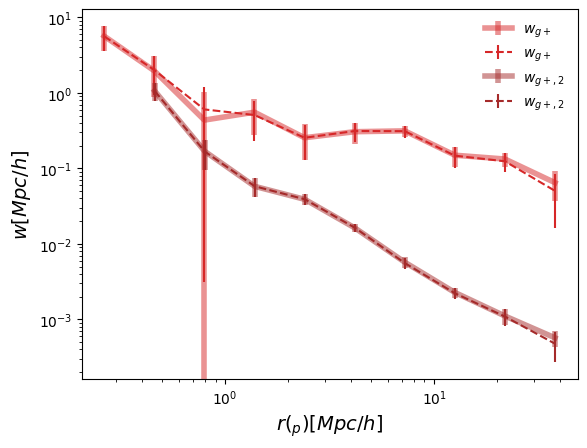

In [43]:
plt.errorbar(corr.wgp.rp,corr.wgp.xip,yerr=corr.wgp.std_from_cov,label=r'$w_{g+}$',c='C3',alpha = 0.5,lw=4)
plt.errorbar(corr.wgp_fast.rp,corr.wgp_fast.xip,yerr=corr.wgp_fast.std_from_cov,label=r'$w_{g+}$',c='C3',ls='--')
plt.errorbar(corr.wgp2.r,corr.wgp2.xip,yerr=corr.wgp2.std_from_cov,label=r'$w_{g+,2}$',c='brown',alpha = 0.5,lw=4)
plt.errorbar(corr.wgp2_fast.r,corr.wgp2_fast.xip,yerr=corr.wgp2_fast.std_from_cov,label=r'$w_{g+,2}$',c='brown',ls='--')
plt.xscale('log')
plt.yscale('log')
plt.ylabel(r'$w[Mpc/h]$',fontsize=14)
plt.xlabel(r'$r(_p) [Mpc/h]$',fontsize=14)
plt.legend(frameon=False)